# Identificación de carros con redes neuronales convolucionales

Se utilizará un set de imágenes para detectar carros en una carretera.

Dirección del set de datos: https://www.kaggle.com/datasets/sshikamaru/car-object-detection<br/>
Cantidad de imágenes: 1178

El objetivo de aprender redes neuronales convolucionales para detección de objetos es para poder continuar un proyecto personal
que incluya radares Lidar.

# Librerías a utilizar en el proyecto

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import Recall, BinaryAccuracy, Precision
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf

Evita imprimir varios logs al momento de entrenar el modelo con Keras

In [2]:
from tqdm.keras import TqdmCallback

# Carga de datos

El siguiente listado contiene que imagenes tienen un carro y las coordenadas en pixeles de donde se encuentra el carro.

In [3]:
y_carros = pd.read_csv('data2/data/train_solution_bounding_boxes (1).csv') 
print("Registros:", len(y_carros))
y_carros.head()

Registros: 559


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


Tamaño de las imagenes

In [4]:
image_width = 676
image_height = 380

Normalizando pixeles

In [5]:
y_carros.xmin = y_carros.xmin / image_width
y_carros.ymin = y_carros.ymin / image_height
y_carros.xmax = y_carros.xmax / image_width
y_carros.ymax = y_carros.ymax / image_height

Carga de imagenes para entrenamiento

In [6]:
x_carros = pd.DataFrame({'image': os.listdir('data2/data/training_images/images/')})
print("Registros:", len(x_carros))
x_carros.head()

Registros: 1001


,image
0,vid_4_1000.jpg
1,vid_4_10000.jpg
2,vid_4_10020.jpg
3,vid_4_10040.jpg
4,vid_4_10060.jpg


Uniendo ambos set de datos.

In [7]:
carros = x_carros.merge(y_carros, how = 'left', on = ['image'])
print("Registros:", len(carros))
carros.head()

Registros: 1205


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,0.416064,0.492198,0.484805,0.587436
1,vid_4_10000.jpg,0.022431,0.492198,0.178003,0.622185
2,vid_4_10020.jpg,0.734443,0.453588,0.931983,0.609315
3,vid_4_10040.jpg,0.353835,0.465171,0.535456,0.622185
4,vid_4_10060.jpg,0.024602,0.490911,0.196093,0.627333


Identificando por que el set de datos resultantes es mayor a las imagenes de entrenamiento:

In [8]:
carros_duplicados = carros["image"]
carros_duplicados = carros_duplicados[carros["image"].duplicated()].reset_index(drop=True)
carros_duplicados

0      vid_4_12140.jpg
1      vid_4_12160.jpg
2      vid_4_12160.jpg
3      vid_4_12180.jpg
4      vid_4_12180.jpg
            ...       
199     vid_4_9640.jpg
200     vid_4_9760.jpg
201     vid_4_9760.jpg
202     vid_4_9780.jpg
203     vid_4_9800.jpg
Name: image, Length: 204, dtype: object

Una imagen puede tener más de un carro:

In [9]:
ejemplo_duplicado = carros[carros["image"] == carros_duplicados[0]]
ejemplo_duplicado

,image,xmin,ymin,xmax,ymax
101,vid_4_12140.jpg,0.309696,0.485763,0.469609,0.592584
102,vid_4_12140.jpg,0.876266,0.445866,0.949349,0.553974


Función para graficar recuadros:

In [10]:
def graficar_cuadros(ruta, coordenadas):
    im = Image.open(ruta)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)
    
    for row in coordenadas.iterrows():
        # Create a Rectangle patch
        xmin = row[1]["xmin"]*image_width
        ymin = row[1]["ymin"]*image_height
        xmax = row[1]["xmax"]*image_width
        ymax = row[1]["ymax"]*image_height
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Add the patch to the Axes
    plt.show()

Graficando los carros en la imagen:

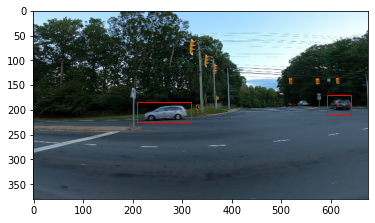

In [11]:
ruta = 'data2/data/training_images/images/'+ejemplo_duplicado.iloc[0,0]
coordenadas = ejemplo_duplicado.iloc[:,1:5]
graficar_cuadros(ruta, coordenadas)

Para evitar duplicar registros para cada carro, se agregarán más columnas para registrar hasta 10 carros. El siguiente código agrega un registro de imagen una sola vez:

In [12]:
carros_duplicados = y_carros[y_carros["image"].duplicated()]
carros_sin_duplicar = y_carros[y_carros["image"].duplicated()==False]

carros = x_carros.merge(carros_sin_duplicar, how = 'left', on = ['image'])
carros.insert(1, 'carros', 1)

sin_carros = carros["xmin"].isnull()
carros.loc[sin_carros, ["carros", "xmin", "ymin", "xmax", "ymax"]] = 0
print("Registros:", len(carros))
carros.head()

Registros: 1001


,image,carros,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333


A conginuación se agregarán la cantidad necesarias de columnas para registrar las coordenadas de la maxima cantidad de carros en una imagen.

In [13]:
maxima_repitencia = max(carros_duplicados.groupby('image').size()) + 1
print("Maxima repitencia:", maxima_repitencia)
for i in range(2, maxima_repitencia + 2):
    s = str(i)
    carros.loc[:, ["xmin"+str(i), "ymin"+str(i), "xmax"+str(i), "ymax"+str(i)]] = 0
carros = carros.rename(columns={"xmin": "xmin1", "ymin": "ymin1", "xmax": "xmax1", "ymax": "ymax1"})
carros.head()

Maxima repitencia: 7


,image,carros,xmin1,ymin1,xmax1,ymax1,xmin2,ymin2,xmax2,ymax2,...,xmax6,ymax6,xmin7,ymin7,xmax7,ymax7,xmin8,ymin8,xmax8,ymax8
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se agregan los registros de coordenadas de donde hay más de un carro:

In [14]:
for image in np.unique(carros_duplicados["image"]):
    registros_duplicados = carros_duplicados[carros_duplicados["image"] == image]
    carros_indice = np.array(carros["image"] == image).argmax()
    index = 2
    for registro_duplicado in registros_duplicados.reset_index(drop=True).iterrows():
        registro_duplicado = registro_duplicado[1]
        carros.iloc[carros_indice, index*4-2] = registro_duplicado["xmin"]
        carros.iloc[carros_indice, index*4-1] = registro_duplicado["ymin"]
        carros.iloc[carros_indice, index*4] = registro_duplicado["xmax"]
        carros.iloc[carros_indice, index*4+1] = registro_duplicado["ymax"]
        index = index + 1
carros.head()

,image,carros,xmin1,ymin1,xmax1,ymax1,xmin2,ymin2,xmax2,ymax2,...,xmax6,ymax6,xmin7,ymin7,xmax7,ymax7,xmin8,ymin8,xmax8,ymax8
0,vid_4_1000.jpg,1,0.416064,0.492198,0.484805,0.587436,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,vid_4_10000.jpg,1,0.022431,0.492198,0.178003,0.622185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,vid_4_10020.jpg,1,0.734443,0.453588,0.931983,0.609315,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,vid_4_10040.jpg,1,0.353835,0.465171,0.535456,0.622185,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,vid_4_10060.jpg,1,0.024602,0.490911,0.196093,0.627333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


Labels x y

In [15]:
columnas_x = ["image"]
columnas_y = ["carros", "xmin1", "ymin1", "xmax1", "ymax1"]
for i in range(2, maxima_repitencia + 1):
    s=str(i)
    columnas_y.append("xmin"+s)
    columnas_y.append("ymin"+s)
    columnas_y.append("xmax"+s)
    columnas_y.append("ymax"+s)
print("Columnas X:", columnas_x)
print("Columnas Y:", columnas_y)

Columnas X: ['image']
Columnas Y: ['carros', 'xmin1', 'ymin1', 'xmax1', 'ymax1', 'xmin2', 'ymin2', 'xmax2', 'ymax2', 'xmin3', 'ymin3', 'xmax3', 'ymax3', 'xmin4', 'ymin4', 'xmax4', 'ymax4', 'xmin5', 'ymin5', 'xmax5', 'ymax5', 'xmin6', 'ymin6', 'xmax6', 'ymax6', 'xmin7', 'ymin7', 'xmax7', 'ymax7']


# Carga de imagnenes

Cargando las imagnes

In [16]:
list_ds = tf.data.Dataset.list_files(str('./data2/data/training_images/images/*'), shuffle=False)
val_size = int(len(carros) * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Obteniendo labels para entrenamiento y validación:

In [41]:
apartar = int(len(carros)*0.2)+1
validation_x = carros.loc[0:apartar,columnas_x].reset_index(drop=True)
validation_y = carros.loc[0:apartar,columnas_y].reset_index(drop=True)
train_x = carros.loc[apartar:(apartar+len(carros)),columnas_x].reset_index(drop=True)
train_y = carros.loc[apartar:(apartar+len(carros)),columnas_y].reset_index(drop=True)

Convirtiendo labels a tensores:

In [18]:
validation_x = tf.convert_to_tensor(np.array(validation_x), dtype=tf.string)
validation_y = tf.convert_to_tensor(np.array(validation_y), dtype=tf.float32) 
train_x = tf.convert_to_tensor(np.array(train_x), dtype=tf.string) 
train_y = tf.convert_to_tensor(np.array(train_y), dtype=tf.float32) 

Decodificar y cargar imagenes:

In [19]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.shape(img), tf.image.resize(img, [256, 256])

#@tf.function
def process_path(file_path, tf_x, tf_y):
    img = tf.io.read_file(file_path)
    shape, img = decode_img(img)
    
    parts = tf.strings.split(file_path, os.path.sep)
    label = tf.gather(tf_y, tf.math.argmax(tf_x==parts[-1]))
    
    #logits = tf.TensorArray(tf.int32, size=maxima_repitencia*4)
    #logits = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    #logits = tf.Variable(lambda: tf.zeros(maxima_repitencia*4, tf.float32))
    
    #Escalar coordenadas
    #for i in range(0, maxima_repitencia):
        #print("test")
        #logits.write(i*4, tf.math.divide(label[0,i*4+1],shape[0]))
        #logits = logits.write(i*4, tf.math.divide(tf.cast(label[0,i*4+1], tf.float32), tf.cast(shape[0], tf.float32)))
        #logits = logits.write(i*4+1, tf.math.divide(tf.cast(label[0,i*4+1], tf.float32), tf.cast(shape[0], tf.float32)))
        #logits = logits.write(i*4+2, tf.math.divide(tf.cast(label[0,i*4+1], tf.float32), tf.cast(shape[0], tf.float32)))
        #logits = logits.write(i*4+3, tf.math.divide(tf.cast(label[0,i*4+1], tf.float32), tf.cast(shape[0], tf.float32)))
        
        #label[0,i*4+1] = tf.math.divide(label[0,i*4+1],shape[0]) 
        #label[0,i*4+2] = tf.math.divide(label[0,i*4+2],shape[1])
        #label[0,i*4+3] = tf.math.divide(label[0,i*4+3],shape[0])
        #label[0,i*4+4] = tf.math.divide(label[0,i*4+4],shape[1])
        
        #logits[i*4].assign(tf.math.divide(tf.cast(label[0,i*4+1], tf.float32), tf.cast(shape[0], tf.float32)))
        #logits[i*4+1].assign(tf.math.divide(tf.cast(label[0,i*4+2], tf.float32), tf.cast(shape[1], tf.float32)))
        #logits[i*4+2].assign(tf.math.divide(tf.cast(label[0,i*4+3], tf.float32), tf.cast(shape[0], tf.float32)))
        #logits[i*4+3].assign(tf.math.divide(tf.cast(label[0,i*4+4], tf.float32), tf.cast(shape[1], tf.float32)))
        
    return img, {"has_car":label[0,0], "coordinates":label[0,1:]}
    #return img, {"has_car":label[0,0], "coordinates":logits}

def process_path_train(file_path):
    return process_path(file_path, train_x, train_y)

def process_path_validation(file_path):
    return process_path(file_path, validation_x, validation_y)

train_ds = train_ds.map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(process_path_validation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Configuración de rendimiento

In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# Modelo keras

## Proceso convolucional

In [37]:
input_layer = Input(shape=(256, 256, 3), name="input")

#primera capa convolucional
capa_convolucional = Conv2D(filters=256, kernel_size=(3,3), name="conv")(input_layer)

#capa maxpooling
capa_maxpooling = MaxPool2D(pool_size=(2,2), name="maxpool")(capa_convolucional)

#segunda capa convolucional
segunda_capa_convoluiconal = Conv2D(filters=128, kernel_size=(3,3), activation='relu', name="conv2")(capa_maxpooling)

#segunda capa de maxpooling
segunda_capa_maxpooling = MaxPool2D(pool_size=(2,2), name="maxpool2")(segunda_capa_convoluiconal)

#capa de flatten
capa_flatten = Flatten(name="flatten")(segunda_capa_maxpooling)

## Optimizador

In [22]:
adagrad = Adagrad( learning_rate=0.01,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad"
)

## Custom callback

In [23]:
class custom_callback(Callback):
    def __init__(self):
        self.f1score = 0
    
    def get_f1score(self):
        return self.f1score
    
    def set_f1score(self, recall, precision):
        denominador = recall + precision
        if( denominador == 0):
            self.f1score = 0
        else:
            self.f1score = (2*(recall * precision) / denominador)
    
    def on_epoch_end(self, batch, logs=None):
        recall = logs.get('recall')
        accuracy = logs.get('accuracy')
        precision = logs.get('precision')
        self.set_f1score(recall, precision)
        
        if( accuracy > 0.95 ):
            self.model.stop_training = True

## Fase feedfoarward

In [38]:
#Fase artificial
capa_artificial = Dense(64, activation="relu", kernel_initializer=GlorotNormal(), name="artificial")(capa_flatten)
capa_regularizacion = Dropout(0.1, input_shape=(64,), name="regularizacion")(capa_artificial)
segunda_capa_artificial = Dense(64, activation="relu", kernel_initializer=GlorotNormal(), name="artificial2")(capa_regularizacion)
segunda_capa_regularizacion = Dropout(0.1, input_shape=(64,), name="regularizacion2")(segunda_capa_artificial)

#Salida
binary_output = Dense(1, activation="softmax", name="has_car")(segunda_capa_regularizacion)
regression_output = Dense(maxima_repitencia*4, activation="softmax", name="coordinates")(segunda_capa_regularizacion)
output_array = [binary_output, regression_output]

modelo = Model(inputs=input_layer, outputs=output_array, name="modelo")

callbacks_modelo = custom_callback()
modelo.compile(
    loss={"has_car":BinaryCrossentropy(from_logits=False), "coordinates":MeanSquaredError()}, 
    optimizer=adagrad, 
    metrics=[Recall(name="recall"), BinaryAccuracy(name="accuracy"), Precision(name="precision")])

In [39]:
historial = modelo.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=20,
    steps_per_epoch=32, 
    verbose=0,
    callbacks=[callbacks_modelo, TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'